In [2]:
import cv2
import numpy as np
from common_functions import *
from skimage.filters import threshold_minimum,threshold_otsu
from skimage.exposure import equalize_hist
from scipy.ndimage import binary_erosion,binary_closing,binary_opening,binary_dilation


## Find Card David

In [31]:


def Erode(img,windowSize):
    window=np.ones((windowSize,windowSize))
    Final=np.zeros(img.shape)
    for i in range(img.shape[0]-windowSize+1):
        for j in range(img.shape[1]-windowSize+1):
            Fit=np.all(np.logical_and(window,img[i:i+windowSize,j:j+windowSize]))
            Final[i,j]=Fit
    return Final

def Dilate(img,windowSize):
    window=np.ones((windowSize,windowSize))
    Final=np.zeros(img.shape)
    for i in range(img.shape[0]-windowSize+1):
        for j in range(img.shape[1]-windowSize+1):
            Hit=np.any(np.logical_and(window,img[i:i+windowSize,j:j+windowSize]))
            Final[i,j]=Hit
    return Final 
# import expsure from skimage
from skimage import exposure
def Gamma_correction(img,gamma):
    img = img / img.max()
    img = img* 255
    img = img.astype(np.uint8)
    img = exposure.adjust_gamma(img, gamma)
    return img

def houghTransform(img):
    orgimg=img.copy()
    cdst = orgimg.copy()
    cdstP = np.copy(cdst)
    
    lines = cv2.HoughLines(orgimg, 1, np.pi / 180, 150, None, 0, 0)
    
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(cdst, pt1, pt2, (255,255,255), 2, cv2.LINE_AA)
    
    
    linesP = cv2.HoughLinesP(orgimg, 1, np.pi / 180, 50, None, 50, 60)
    
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (255,255,255), 2, cv2.LINE_AA)
    
    return cdstP

In [ ]:
image = cv2.imread('../imgs/17.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
grayPolygon = gray.copy()

gray_image=Gamma_correction(gray,2.2)
# Apply bilateralFilter to reduce noise and help contour detection
blurred = cv2.bilateralFilter(gray, 80, 50, 5)
blurred = cv2.GaussianBlur(blurred, (11, 11),0)



threshold = threshold_minimum(gray_image) 
mask = gray_image > threshold
binary_image = np.zeros(gray_image.shape)
binary_image[mask] = 255 


binary_image = binary_image.astype(np.uint8)


3908


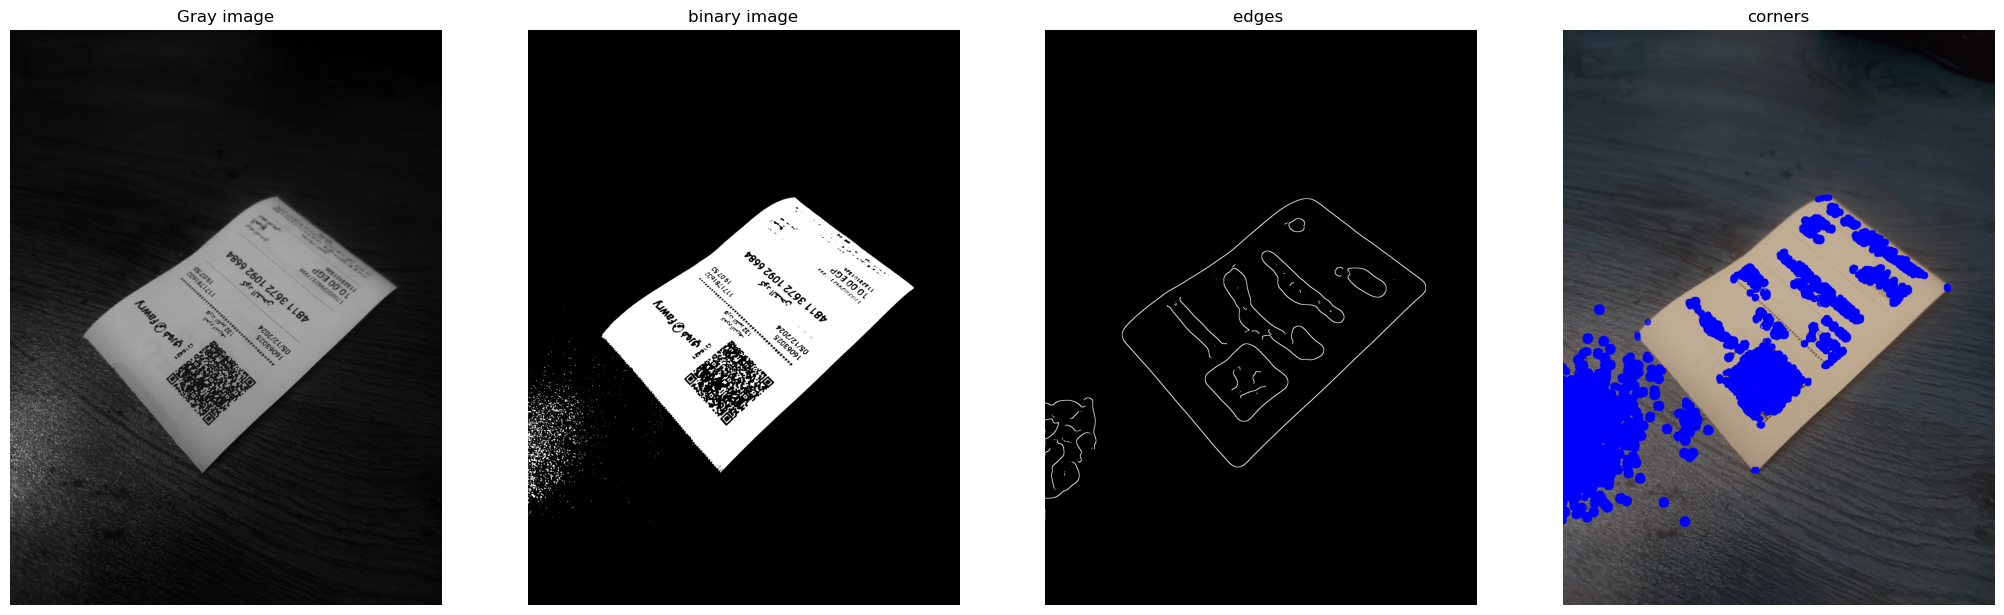

In [ ]:


edges = canny(binary_image, sigma=50, low_threshold=0.5, high_threshold=0.6)
edges = Dilate(edges,5)
# float_image = edges.astype(np.float32) 
# dst = cv2.cornerHarris(src=float_image,blockSize=150,ksize=31,k=0.04)
# dst = cv2.dilate(dst,None)
# corners = np.argwhere(dst > 0.7 * dst.max()) 
# print(len(corners))
# for corner in corners:
#     y, x = corner
#     cv2.circle(image, (x, y), radius=20, color=(0, 0, 255), thickness=2)


# show_images([gray_image, binary_image, edges,image], ["Gray image", "binary image",'edges ','corners'])

In [ ]:
def find_card(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
   # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayPolygon = gray.copy()

    gray_image=Gamma_correction(gray,2.2)
    # Apply bilateralFilter to reduce noise and help contour detection
    blurred = cv2.bilateralFilter(gray, 80, 50, 5)
    blurred = cv2.GaussianBlur(blurred, (11, 11),0)



    threshold = threshold_minimum(gray_image) 
    mask = gray_image > threshold
    binary_image = np.zeros(gray_image.shape)
    binary_image[mask] = 255 
    binary_image = binary_image.astype(np.uint8)
    edges = canny(binary_image, sigma=50, low_threshold=0.5, high_threshold=0.6)
    preProcessedImage = Dilate(edges,5) 

    # preProcessedImage = (edges * 255).astype(np.uint8)
    
    if len(preProcessedImage.shape) == 3:
        preProcessedImage = cv2.cvtColor(preProcessedImage, cv2.COLOR_BGR2GRAY)
    # To exit if number of iteraitons exceeds 5
    iterations = 0
    # To check if the card is detected
    rectangular_contours = []
    while (len(rectangular_contours) < 1):
        # dilation4 is the variable name that is used when finding contours
        if (iterations == 0):
            preProcessedImage = edges
        # If the card is not detected, apply Hough
        elif iterations == 1:
            preProcessedImage = cv2.dilate(preProcessedImage, np.ones((3,3)))
            preProcessedImage = cv2.erode(preProcessedImage, np.ones((3,3)))
        elif iterations == 2:
            preProcessedImage = houghTransform(preProcessedImage) 
        elif (iterations > 7):
            return image
        else:
            preProcessedImage = houghTransform(preProcessedImage) 
            # Apply opening and closing to the image to remove noise
            preProcessedImage = cv2.erode(preProcessedImage, np.ones((3,3)))
            preProcessedImage = cv2.dilate(preProcessedImage, np.ones((3,3)))
            preProcessedImage = cv2.dilate(preProcessedImage, np.ones((7,7)))
            preProcessedImage = cv2.erode(preProcessedImage, np.ones((7,7)))
        iterations += 1

        # Convert image to uint8 if necessary
        if preProcessedImage.dtype != np.uint8:
            preProcessedImage = (preProcessedImage * 255).astype(np.uint8)
        contours, _ = cv2.findContours(preProcessedImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Filter contours based on area to find the card contour
        card_contour = None
        approx_polygon = None
        rectangular_contours = []
        max_area = 0
        for contour in contours:
            # Calculate the area of each contour
            area = cv2.contourArea(contour)
            if area > 30000:
                # Approximate the contour with a polygon
                peri = cv2.arcLength(contour, True)
                approx_polygon = cv2.approxPolyDP(contour, 0.015 * peri, True)
                # If the contour has 4 corners and its area is the maximum so far, then it is the card contour
                if area > max_area and len(approx_polygon) == 4:
                    cv2.polylines(grayPolygon, [approx_polygon], isClosed=True, color=(0, 255, 0), thickness=5)
                    card_contour = approx_polygon
                    max_area = area
                    rectangular_contours.append(approx_polygon)
        
    # Get the coordinates of the polygon's vertices (corners)
    corners = np.squeeze(card_contour)
    if (corners.any() == None):
        return image
    if (len(corners) != 4):
        return image
    
    # Pixel values in the original image
    points = card_contour.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")

    topY = np.argmin(corners[:, 1])
    bottomY = np.argmax(corners[:, 1])
    rightX = np.argmax(corners[:, 0])
    leftX = np.argmin(corners[:, 0])
    
    caseNum = 0
    
    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]

    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]

    (top_left, top_right, bottom_left, bottom_right) = input_points
    bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
    right_height = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
    left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))
    
    if(max(top_width, bottom_width) < max(right_height, left_height)):
        if corners[rightX][1] < corners[leftX][1]: #clockwise
            temp = input_points[0].copy()
            input_points[0] = input_points[2]
            input_points[2] = input_points[3]
            input_points[3] = input_points[1]
            input_points[1] = temp
        else:   #counter clockwise
            temp = input_points[0].copy()
            input_points[0] = input_points[1]
            input_points[1] = input_points[3]
            input_points[3] = input_points[2]
            input_points[2] = temp

    # Output image size
    max_width = 1024

    max_height = 650  

    # Desired points values in the output image
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

    # Perspective transformation
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    img_output = cv2.warpPerspective(image, matrix, (max_width, max_height))
    
    # Draw the polygon on the original image
    image_with_polygon = image.copy()
    cv2.polylines(image_with_polygon, [approx_polygon], isClosed=True, color=(0, 255, 0), thickness=2)

    show_images([image, img_output], ["Original image", "Output image"])
    
    return img_output

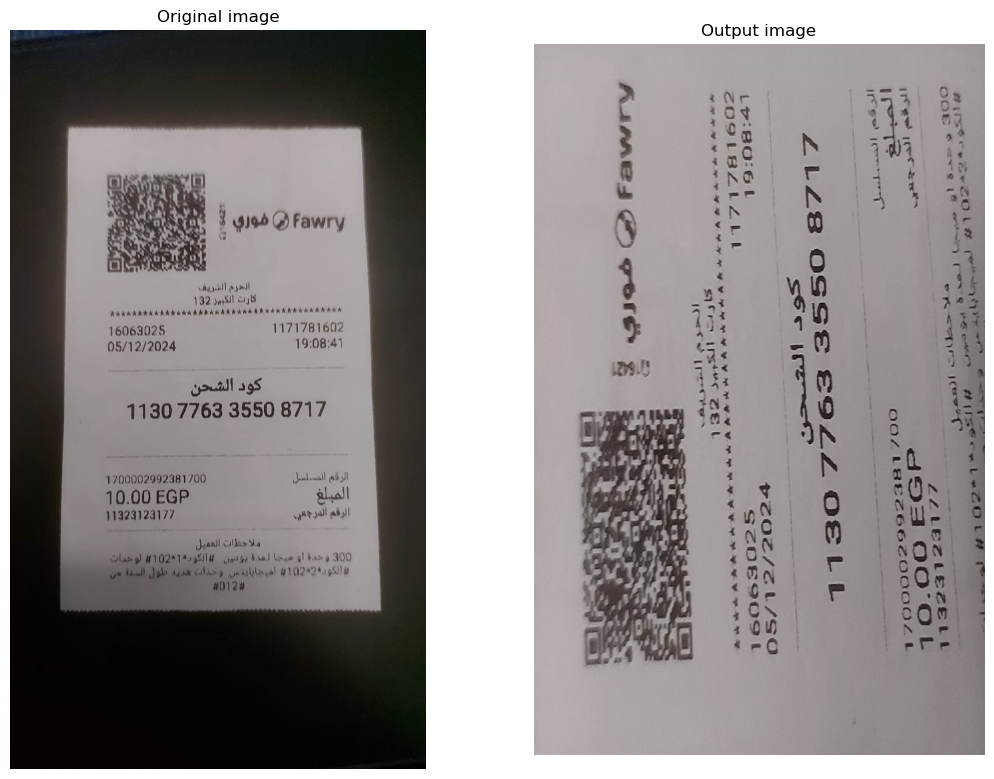

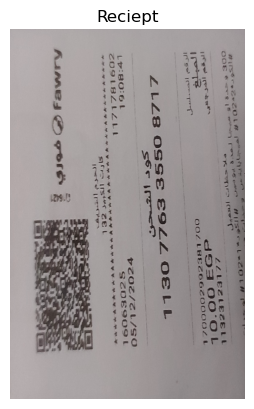

In [130]:
reciept = find_card("../imgs/0.jpeg")   
show_images([reciept], ["Reciept"])

# modularized

## `load_and_preprocess_image`
### Description
Loads the image, converts it to grayscale, and applies gamma correction.

### Parameters
- **`image_path`** *(str)*: Path to the input image file.

### Returns
- **`image`** *(ndarray)*: Original image.
- **`gray`** *(ndarray)*: Grayscale version of the image.
- **`gray_image`** *(ndarray)*: Gamma-corrected grayscale image.

---


In [ ]:

def load_and_preprocess_image(image_path):
    """Loads the image, converts it to grayscale, and applies gamma correction."""
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = Gamma_correction(gray, 2.2)
    return image, gray, gray_image

def reduce_noise(gray_image):
    """Applies noise reduction techniques to the grayscale image."""
    blurred = cv2.bilateralFilter(gray_image, 80, 50, 5)
    blurred = cv2.GaussianBlur(blurred, (11, 11), 0)
    return blurred

def threshold_and_edge_detection(gray_image):
    """Applies thresholding and edge detection to preprocess the image for contour detection."""
    threshold = threshold_minimum(gray_image)
    mask = gray_image > threshold
    binary_image = np.zeros(gray_image.shape)
    binary_image[mask] = 255
    binary_image = binary_image.astype(np.uint8)
    edges = canny(binary_image, sigma=50, low_threshold=0.5, high_threshold=0.6)
    return Dilate(edges, 5)

def apply_iterations(preProcessedImage, edges):
    """Iteratively processes the image using various transformations until contours are found."""
    iterations = 0
    while iterations <= 7:
        if iterations == 0:
            preProcessedImage = edges
        elif iterations == 1:
            preProcessedImage = cv2.dilate(preProcessedImage, np.ones((3, 3)))
            preProcessedImage = cv2.erode(preProcessedImage, np.ones((3, 3)))
        elif iterations == 2:
            preProcessedImage = houghTransform(preProcessedImage)
        else:
            preProcessedImage = houghTransform(preProcessedImage)
            preProcessedImage = cv2.erode(preProcessedImage, np.ones((3, 3)))
            preProcessedImage = cv2.dilate(preProcessedImage, np.ones((3, 3)))
            preProcessedImage = cv2.dilate(preProcessedImage, np.ones((7, 7)))
            preProcessedImage = cv2.erode(preProcessedImage, np.ones((7, 7)))

        iterations += 1

        if preProcessedImage.dtype != np.uint8:
            preProcessedImage = (preProcessedImage * 255).astype(np.uint8)

        contours, _ = cv2.findContours(preProcessedImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(filter_card_contours(contours)) > 0:
            return preProcessedImage, contours

    return preProcessedImage, []

def filter_card_contours(contours):
    """Filters contours to find a rectangular contour with 4 corners and a large area."""
    rectangular_contours = []
    max_area = 0
    card_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 30000:
            peri = cv2.arcLength(contour, True)
            approx_polygon = cv2.approxPolyDP(contour, 0.015 * peri, True)
            if area > max_area and len(approx_polygon) == 4:
                rectangular_contours.append(approx_polygon)
                card_contour = approx_polygon
                max_area = area
    return rectangular_contours, card_contour

def find_polygon_corners(card_contour):
    """Identifies the corners of the detected polygon."""
    points = card_contour.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")
    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]
    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]
    return input_points

def transform_perspective(image, input_points):
    """Performs a perspective transformation on the image."""
    max_width = 1024
    max_height = 650
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    img_output = cv2.warpPerspective(image, matrix, (max_width, max_height))
    return img_output

def find_card(image_path):
    """Main function to detect a card in an image and return the transformed perspective."""
    image, gray, gray_image = load_and_preprocess_image(image_path)
    blurred = reduce_noise(gray)
    edges = threshold_and_edge_detection(gray_image)
    preProcessedImage, contours = apply_iterations(edges, edges)
    rectangular_contours, card_contour = filter_card_contours(contours)

    if not card_contour:
        return image

    input_points = find_polygon_corners(card_contour)
    img_output = transform_perspective(image, input_points)
    return img_output


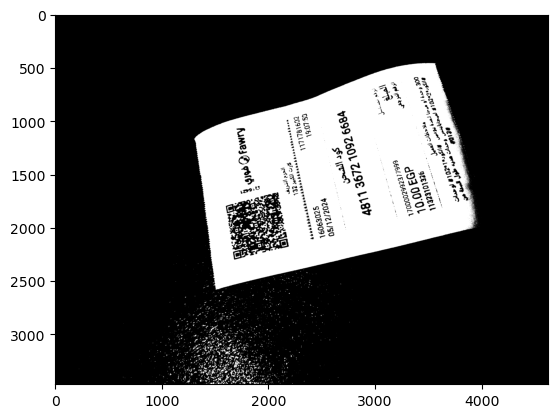

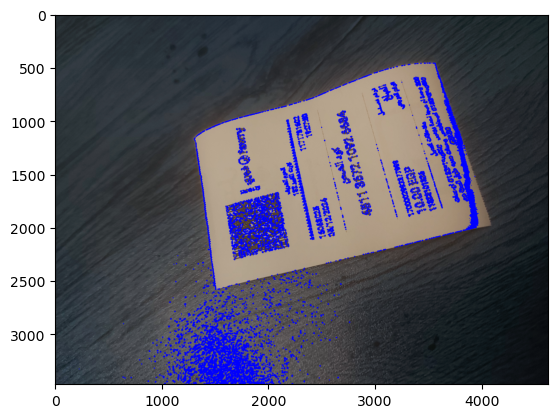

'  \n\nblock size : size of the neighborhood considered for corner detection\nksize : aperture parameter of Sobel derivative used\nk : Harris detector free parameter in the equation\n'

In [24]:
original_image = io.imread('../imgs/14.jpg') 
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)



threshold = threshold_minimum(gray_image) 
mask = gray_image > threshold
binary_image = np.zeros(gray_image.shape)
binary_image[mask] = 255 
plt.imshow(binary_image,cmap='gray')
plt.show()


float_image = binary_image.astype(np.float32) 
dst = cv2.cornerHarris(src=float_image,blockSize=10,ksize=3,k=0.04)
dst = cv2.dilate(dst,None)
original_image[dst > 0.01*dst.max()] = [0,0,255]
plt.imshow(original_image)
plt.show()

# threshold = 0.01 * dst.max()

# Find coordinates of corners
# corners = np.argwhere(dst > threshold)
# print(len(corners))
# # Draw circles at the corners
# for corner in corners:
#     y, x = corner
#     cv2.circle(original_image, (x, y), radius=5, color=(0, 0, 255), thickness=2)

# # Display the result
# cv2.imshow('Corners', original_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
'''  

block size : size of the neighborhood considered for corner detection
ksize : aperture parameter of Sobel derivative used
k : Harris detector free parameter in the equation
''' 
# original_image[dst>0.01*dst.max()]=[0,0,255]
# plt.imshow(original_image)

# gray_image = rgb2gray(original_image)
# threshold = threshold_minimum(gray_image) 
# mask = gray_image > threshold
# binary_image = np.zeros(gray_image.shape)
# binary_image[mask] = 255

# binary_image = binary_image.astype(np.uint8)
# gray_image = gray_image.astype(np.uint8)
# corners = cv2.goodFeaturesToTrack(gray_image, maxCorners=4 ,qualityLevel=0.01, minDistance=1000, blockSize=3, k=0.04)
# print(corners)
# for corner in corners:
#     x, y = corner.ravel()
#     cv2.circle(original_image, (int(x), int(y)), 20, 255, -1)
# show_images([original_image],['corners'])

# print(corners)

# for corner in corners:
#     x, y = corner.ravel()
#     cv2.circle(original_image, (int(x), int(y)), 20, 255, -1)
    
# show_images([binary_image,original_image],['binary imge','corners'])

